# Using knowledge graphs to build GraphRAG applications with Amazon Bedrock and Amazon Neptune

In this notebook, we will run a GraphRAG sample using Amazon Bedrock and Amazon Neptune. More details can be found on [AWS blog post](https://aws.amazon.com/blogs/database/using-knowledge-graphs-to-build-graphrag-applications-with-amazon-bedrock-and-amazon-neptune/).

This is the architecture of the setup.

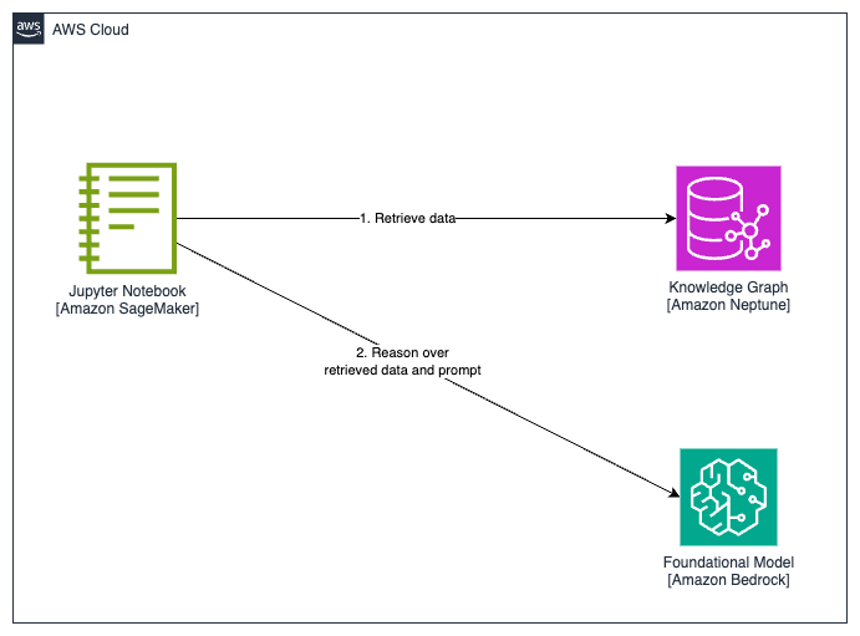

## Preparation

In [ ]:
%pip install llama_index==v0.10.68 llama-index-llms-bedrock llama-index-graph-stores-neptune

Configure the endpoint information. Modify the <b>NEPTUNE_ENDPOINT</b> and <b>NEPTUNE_PORT</b> below then run the command.

In [ ]:
neptune_endpoint = 'NEPTUNE_ENDPOINT'
neptune_port = 'NEPTUNE_PORT'

## Configure Amazon Bedrock with LlamaIndex

In [ ]:
from llama_index.llms.bedrock import Bedrock
from llama_index.core import Settings

llm = Bedrock(model="anthropic.claude-3-sonnet-20240229-v1:0")
Settings.llm = llm

## Integrate Amazon Neptune with LlamaIndex

In [ ]:
from llama_index.core import StorageContext
from llama_index.graph_stores.neptune import NeptuneDatabaseGraphStore

graph_store = NeptuneDatabaseGraphStore(
    host=neptune_endpoint,
    port=neptune_port,
    node_label="User"
)
storage_context = StorageContext.from_defaults(graph_store=graph_store)


## Configure the retriever for Neptune

In [ ]:
from llama_index.core.prompts.base import (
    PromptTemplate,
    PromptType,
)
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.retrievers import KnowledgeGraphRAGRetriever

ENTITY_EXTRACT_TMPL_STR = """
A question is provided below. 
Given the question, extract up to {max_keywords} information that identify a given user in the question. Avoid stopwords.
Focus on extracting complete information from question, it can be more than one single word.
---------------------
{question}
---------------------
Provide information in the following comma-separated format: 'KEYWORDS: <information>'
"""

ENTITY_EXTRACT_PROMPT = PromptTemplate(
    ENTITY_EXTRACT_TMPL_STR,
    prompt_type=PromptType.QUERY_KEYWORD_EXTRACT,
)

AMAZON_NEPTUNE_NL2CYPHER_PROMPT_TMPL_STR = """
Create a **Amazon Neptune flavor Cypher query** based on provided relationship paths and a question.
The query should be able to try best answer the question with the given graph schema.
The query should follow the following guidance:
- Fully qualify property references with the node's label.
```
// Incorrect
MATCH (p:person)-[:follow]->(:person) RETURN p.name
// Correct
MATCH (p:person)-[:follow]->(i:person) RETURN i.name
```
- Strictly follow the relationship on schema:
Given the relationship ['(:`Art`)-[:`BY_ARTIST`]->(:`Artist`)']:
```
// Incorrect
MATCH (a:Artist)-[:BY_ARTIST]->(t:Art)
RETURN DISTINCT t
// Correct
MATCH (a:Art)-[:BY_ARTIST]->(t:Artist)
RETURN DISTINCT t
```
- Follow single direction (from left to right) query model:
```
// Incorrect
MATCH (a:Artist)<-[:BY_ARTIST]-(t:Art)
RETURN DISTINCT t
// Correct
MATCH (a:Art)-[:BY_ARTIST]->(t:Artist)
RETURN DISTINCT t
```
Given any relationship property, you should just use them following the relationship paths provided, respecting the direction of the relationship path.
With these information, construct a Amazon Neptune Cypher query to provide the necessary information for answering the question, only return the plain text query, no explanation, apologies, or other text.
NOTE:
0. Try to get as much graph data as possible to answer the question
1. Put a limit of 30 results in the query.
---
Question: {query_str}
---
Schema: {schema}
---
Amazon Neptune flavor Query:
"""

NL2CYPHER_PROMPT = PromptTemplate(
    AMAZON_NEPTUNE_NL2CYPHER_PROMPT_TMPL_STR,
    prompt_type=PromptType.TEXT_TO_GRAPH_QUERY,
)

graph_rag_retriever = KnowledgeGraphRAGRetriever(
    storage_context=storage_context,
    entity_extract_template=ENTITY_EXTRACT_PROMPT,
    with_nl2graphquery=True,
    graph_query_synthesis_prompt=NL2CYPHER_PROMPT,
    graph_traversal_depth=3,
    # verbose=True, # verbose for showing query
)

query_engine = RetrieverQueryEngine.from_args(
    graph_rag_retriever,
    response_mode="refine"
)

## Interact with the knowledge graph


### Example 1: Armand Aglione

In [154]:
from IPython.display import display, Markdown

response = query_engine.query(
"""
You are a marketing analyst in a Technology retail company, mainly focused on selling notebooks, smartphones and tablets from popular brands.

You need to create hyper-personalized product recommendation for this customer.

Instructions for using the provided information about customer:

1. You should recommend products similar to device models used by customer

```
// Example
Given the user agent: Mozilla/5.0 (x11; Linux Amd64) Apple Web Kit/534.36 (khtml, Like Gecko) Chrome/13.0.766.0 Safari/534.36
The device model is: x11; Linux Amd64
```

2. Web browser information is irrelevant
3. Geographic information should be used to personalize your recommendation
4. Ask for confirmation about contact information

Notes:
- Keep communication friendly and focused on recommending products models
- Include technical details about recommended products models
- Avoid mentioning your role
- Avoid mentioning you are performing a personalized recommendation
- Conclude by putting yourself available to support customer and answer questions

Customer: <id>Armand Aglione</id>
""",
)
display(Markdown(f"<b>{response}</b>"))

<b>Hello Armand,

Based on the information provided, you are located in Tyler, Texas, United States. For customers in your region, I would recommend considering the latest models of tablets and smartphones from popular brands like Apple, Samsung, and Microsoft.

Some options you may want to explore:

Apple iPad Pro (2022 model) - This high-end tablet features the powerful M2 chip, a stunning Liquid Retina XDR display, and advanced cameras. It's perfect for productivity, creativity, and entertainment.

Samsung Galaxy S23 Ultra - Samsung's flagship smartphone boasts a brilliant 6.8-inch Dynamic AMOLED display, a top-of-the-line camera system, and the latest Snapdragon 8 Gen 2 processor for seamless performance.

Microsoft Surface Pro 9 - This versatile 2-in-1 device combines the power of a laptop with the portability of a tablet. It features a vibrant PixelSense display, Intel's latest processors, and excellent stylus support.

Please confirm if the contact information we have on file is correct: Tyler, Texas, United States. I'm happy to provide more details or recommendations based on your specific needs and preferences. Let me know if you have any other questions!</b>

In [155]:
from IPython.display import display, Markdown

response = query_engine.query(
"""
What device is used by this customer? Is this customer using Apple devices?

Instructions:
1. You can find the device model according to the user agent.
```
// Example
Given the user agent: Mozilla/5.0 (x11; Linux Amd64) Apple Web Kit/534.36 (khtml, Like Gecko) Chrome/13.0.766.0 Safari/534.36
The device model is: x11; Linux Amd64
```

Customer: <id>Armand Aglione</id>
""",
)
display(Markdown(f"<b>{response}</b>"))

<b>Based on the graph query response, the customer Armand Aglione has used two different devices:

1. A device with the user agent "Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36". This appears to be an OpenBSD system running on an i386 architecture.

2. A device with the user agent "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/13.0.782.24 Safari/535.1". This is an Apple device running Mac OS X 10.6.8 on an Intel processor.

So to answer the original query, Armand Aglione has used both non-Apple (OpenBSD) and Apple (Mac OS X) devices based on the user agent information provided in the graph query response.</b>

### Example 2: Dedie Doni

In [156]:
from IPython.display import display, Markdown

response = query_engine.query(
"""
You are a marketing analyst for an online store. You need to create product recommendation for this customer.

Instructions for using the provided information about customer:

1. You should recommend new products based on the purchase history.
2. Ask for confirmation about contact information

Notes:
- Keep communication friendly
- Avoid mentioning your role
- Avoid mentioning you are performing a personalized recommendation
- Avoid mentioning you are referring to previously purchased products
- Conclude by putting yourself available to support customer and answer questions

Customer: <id>Dedie Doni</id>
""",
)
display(Markdown(f"<b>{response}</b>"))

<b>Hello Dedie,

Based on your interests, I would recommend trying our Organic Vegetable Broth, Artisanal Cheese Platter, and Sparkling Rosé Wine. These products complement the items you've enjoyed in the past.

Your contact information shows your email as ddoni3@neptunedemos.com and phone number as 610-273-XXXX, residing at 1 Westport Plaza, Philadelphia, Pennsylvania, United States. Could you please confirm if these details are correct?

I'm happy to provide any additional product suggestions or answer any questions you may have. Please feel free to reach out.</b>

In [157]:
from IPython.display import display, Markdown

response = query_engine.query(
"""
List the products this customer purchased before.

Customer: <id>Dedie Doni</id>
""",
)
display(Markdown(f"<b>{response}</b>"))

<b>Based on the graph query response, the products that the customer Dedie Doni has purchased before are:

- Wine - Sicilia Igt Nero Avola
- Tea - Honey Green Tea  
- Eggplant - Regular
- Bagel - Whole White Sesame
- Beef - Tender Tips
- Tea - Herbal Sweet Dreams</b>

In [ ]:
from IPython.display import display, Markdown

response = query_engine.query(
"""
Should I recommend this user to buy iPhone?

Customer: <id>Dedie Doni</id>
""",
)
display(Markdown(f"<b>{response}</b>"))